In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Subset

# Simulate Raw Data; Split Train/Dev/Test

In [2]:
# draw data from two independent Gaussian distributions: 0 = mean (0,0); 1 = mean(1,1); var = 0.1
group0 = np.random.multivariate_normal(mean = [0., 0.], cov = [[0.1, 0.], [0., 0.1]], size=500)
group1 = np.random.multivariate_normal(mean = [1., 1.], cov = [[0.1, 0.], [0., 0.1]], size=500)
group0_label, group1_label = np.zeros(500), np.ones(500)
# shuffle data
X, Y = np.append(group0,group1,axis=0), np.append(group0_label,group1_label,axis=0)
L = len(X)
indices = list(range(L))
np.random.shuffle(indices)
# split train/dev/test
train_indices, dev_indices, test_indices = indices[:int(0.8*L)], indices[int(0.8*L):int(0.9*L)], indices[int(0.9*L):]
Xtrain, Xdev, Xtest = X[train_indices], X[dev_indices], X[test_indices]
Ytrain, Ydev, Ytest = Y[train_indices], Y[dev_indices], Y[test_indices]

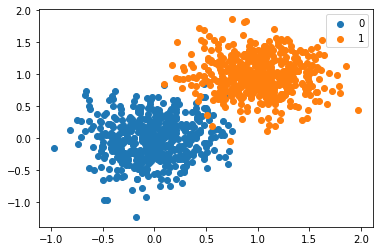

In [3]:
# Let's take a lot at the generated data
plt.figure()
plt.scatter(x=group0.T[0], y=group0.T[1], label=0)
plt.scatter(x=group1.T[0], y=group1.T[1], label=1)
plt.legend()

# Convert to Tensors and Split into batches

In [4]:
# organize data into torch dataloaders
# train
train_set = TensorDataset(torch.tensor(Xtrain), torch.tensor(Ytrain))
train_loader = DataLoader(train_set, batch_size=128)
# dev 
dev_set = TensorDataset(torch.tensor(Xdev), torch.tensor(Ydev))
dev_loader = DataLoader(dev_set, batch_size=128)
# test
test_set = TensorDataset(torch.tensor(Xtest), torch.tensor(Ytest))
test_loader = DataLoader(test_set, batch_size=128)

In [5]:
len(train_set), len(dev_set), len(test_set)

(800, 100, 100)

# Define Neural Network

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim = 2, output_dim=2, n_neurons = 16, activation=nn.Sigmoid):
        
        super(SimpleNet, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_neurons = n_neurons
        
        self.h1=nn.Linear(input_dim, n_neurons)
        self.h2=nn.Linear(n_neurons, n_neurons)
        self.output=nn.Linear(n_neurons, output_dim)
        
        self.activation=activation()
    
    
    def forward(self, x):
        x=self.activation(self.h1(x.float()))
        x=self.activation(self.h2(x))
        x=self.output(x)
        
        return x      

In [7]:
# Code Reference: https://www.kaggle.com/basu369victor/pytorch-tutorial-the-classification

class Classifier():
    
    def __init__(self, network=SimpleNet, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam):
        
        self.network=network()
        self.criterion=criterion()
        self.optimizer=optimizer(self.network.parameters())
    
    def train(self, train_loader, dev_loader=None, n_epochs=10):
        self.network.train()
        for epoch in range(n_epochs):
            batch_loss = 0.
            correct = 0.
            total = 0.
            
            for feature, target in train_loader:
                
                self.optimizer.zero_grad()
                output = self.network(feature)                
                loss = self.criterion(output, target.long())
                
                loss.backward()
                self.optimizer.step()
                
                batch_loss += loss.item()
                _, prediction = torch.max(output, dim=1)
                correct += torch.sum(prediction==target).item()
                total += target.size(0)
            
            if dev_loader != None:
                acc = self.validate(dev_loader)
                print(f"{acc*100.0:.2f}% : dev acc of epoch-{epoch}")

    
    def validate(self, data_loader):
        
        self.network.eval()
        correct = 0.
        total = 0.
        
        with torch.no_grad():
            
            for feature, target in data_loader:
                output = self.network(feature)
                _, prediction = torch.max(output, dim=1)
                correct += torch.sum(prediction==target).item()
                total += target.size(0)
        
        return 1.0 * correct / total
        
    def test(self, data_loader): 
        
        acc = self.validate(data_loader)
        print(f"{acc*100.0:.2f}% : test acc")

In [8]:
myclassifier = Classifier()
myclassifier.train(train_loader, dev_loader)

53.00% : dev acc of epoch-0
53.00% : dev acc of epoch-1
67.00% : dev acc of epoch-2
63.00% : dev acc of epoch-3
54.00% : dev acc of epoch-4
77.00% : dev acc of epoch-5
92.00% : dev acc of epoch-6
99.00% : dev acc of epoch-7
100.00% : dev acc of epoch-8
100.00% : dev acc of epoch-9


In [9]:
myclassifier.test(test_loader)

99.00% : test acc
